<a href="https://colab.research.google.com/github/hhmlai/how-green-is/blob/main/DeepLearning_Segmentation_(Model_training_notebook).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This workbook is adapted from the following tutorial:
* **[Crop type mapping with Deep Learning](http://devseed.com/sat-ml-training/DeepLearning_CropType_Segmentation)** 

This tutorial explains how to segment images according to a set of classes. **Segmentation**  refers to the process of partitioning an image into groups of pixels that identify with a target class (the foreground) or the background.
* **implementing UNet**, a convolutional network model classically used for biomedical image segmentation with the Functional API. 
  * This model has layers that require multiple input/outputs. This requires the use of the functional API
  * The original [paper](https://arxiv.org/abs/1505.04597), 
U-Net: Convolutional Networks for Biomedical Image Segmentation by Olaf Ronneberger.
* **Loss Functions and Metrics** - We'll implement the **Sparse Categorical [focal loss](https://focal-loss.readthedocs.io/en/latest/) function**
 and **accuracy**. We'll also generate confusion matrices during evaluation to judge how well the model performs. 
* **Saving and loading Keras models** - We'll save our best model to file. When we want to perform inference/evaluate our model in the future, we can load the model file. 

### General Workflow
1. Load datasets from Google Drive (from notebook Create sat images and OSD shapes)
2. Compute spectral indices useful for green areas mapping
3. Visualize data/perform some exploratory data analysis
4. Set up data pipeline and preprocessing
5. Build model
6. Train model
7. Test model
8. Evaluate model



## Setup Notebook

In [ ]:
# install required libraries
!pip install -q rasterio
!pip install git+https://github.com/tensorflow/examples.git
!pip install -U tfds-nightly
!pip install focal-loss
!pip install tensorflow_addons

In [ ]:
# import required libraries
import os, glob, functools, fnmatch
from zipfile import ZipFile
from itertools import product

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
from shapely.wkt import loads
import cv2

import rasterio
from rasterio import features, mask, windows
from rasterio.plot import show
import shutil

import tensorflow as tf
from tensorflow.python.keras import layers, losses, models
from tensorflow.python.keras import backend as K  
import tensorflow_addons as tfa

import uuid

from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output


from focal_loss import SparseCategoricalFocalLoss
from sklearn.metrics import confusion_matrix, f1_score

In [ ]:
# mount google drive
from google.colab import drive

drive.flush_and_unmount()

drive.mount('/content/gdrive', force_remount=True)

# set your root directory to the shared drive folder
root_dir = '/content/gdrive/MyDrive/how-green-is/sentinel2_images/'
sat_ref = 'sentinel2'


sat_data_dir = root_dir + 'places/'
tiles_dir = root_dir + 'tiles/' 
personal_dir = root_dir + 'personal/'

year = '2020'

Mounted at /content/gdrive


In [ ]:
[ name for name in os.listdir(sat_data_dir) if os.path.isdir(os.path.join(sat_data_dir, name)) ]

['sentinel2_Paris_Ile-de-France_Metropolitan_France_France',
 'sentinel2_Lisbon_Grande_Lisboa_Area_Metropolitana_de_Lisboa_Portugal',
 'sentinel2_City_of_London_Greater_London_E-0.208443_51.413483__0.126279_51.553736',
 'sentinel2_New_York_United_States-74.084732__40.565633_-73.715668__40.867488',
 'sentinel2_Porto_Area_Metropolitana_do_Porto_North_Portugal',
 'sentinel2_Geneva_Grand_Geneve_Geneva_Swit_6.057677_46.164297__6.256861_46.244768',
 'sentinel2_Zurich_District_Zurich_Zurich_Switzerland',
 'sentinel2_Kyoto_Kyoto_Prefecture_Japa135.611715__34.857388_135.920337__35.104181',
 'sentinel2_Nice_Maritime_Alps_Provence-Alpes-Cote_dAzur_Metropolitan_France_Franc',
 'sentinel2_Seoul_Nowon-gu_South_Korea',
 'sentinel2_Budapest_V._kerulet_Central_Hungary',
 'sentinel2_Barcelona_Barcelones_Barcelona__2.065751_41.342794__2.241125_41.465713',
 'sentinel2_Munich_Bavaria_Germany',
 'sentinel2_Berlin_Germany13.17139__52.395436_13.625622_52.638341',
 'sentinel2_Singapore103.634137___1.247307_103

Now let's divide the Sentinel 2 index stack and labeled image into 224x224 pixel tiles

In [ ]:
sat_folders = ['sentinel2_Paris_Ile-de-France_Metropolitan_France_France',

 'sentinel2_City_of_London_Greater_London_E-0.208443_51.413483__0.126279_51.553736',
 'sentinel2_New_York_United_States-74.084732__40.565633_-73.715668__40.867488',
 'sentinel2_Porto_Area_Metropolitana_do_Porto_North_Portugal',
 'sentinel2_Geneva_Grand_Geneve_Geneva_Swit_6.057677_46.164297__6.256861_46.244768',
 'sentinel2_Kyoto_Kyoto_Prefecture_Japa135.611715__34.857388_135.920337__35.104181',
 'sentinel2_Nice_Maritime_Alps_Provence-Alpes-Cote_dAzur_Metropolitan_France_Franc',
 'sentinel2_Seoul_Nowon-gu_South_Korea',
 'sentinel2_Budapest_V._kerulet_Central_Hungary',
 'sentinel2_Barcelona_Barcelones_Barcelona__2.065751_41.342794__2.241125_41.465713',
 'sentinel2_Munich_Bavaria_Germany',
 'sentinel2_Berlin_Germany13.17139__52.395436_13.625622_52.638341',
 'sentinel2_Singapore103.634137___1.247307_103.980306___1.474294',
 'sentinel2_San_Francisco_Californi-122.519243___37.624746_-122.345242___37.822441',
 'sentinel2_Vancouver_District_of_N-123.269962___49.179758_-122.764446___49.317215',
 'sentinel2_Amsterdam_North_Holland_Netherl_4.723678_52.286642__5.0758___52.437874',
 'sentinel2_Rio_de_Janeiro_Regiao_Geogr-43.458026_-23.063307_-43.145742_-22.774915',
 'sentinel2_Stockholms_kommun_Stockholm_County_Sweden',
 'sentinel2_Santiago_Provincia_de_Santi-70.746321_-33.542921_-70.534773_-33.376412']

sat_folders_test = [
 'sentinel2_Lisbon_Grande_Lisboa_Area_Metropolitana_de_Lisboa_Portugal',
 'sentinel2_Zurich_District_Zurich_Zurich_Switzerland',
 'sentinel2_Malacca_Malaysia102.179527___2.150869_102.343225___2.293356'
 ]

### Read into tensorflow datasets

Now we will compile the spectral index image and label tiles into training, validation, and test datasets for use with TensorFlow.

In [ ]:
# get lists of image and label tile pairs for training and testing

def get_train_test_lists(imdir, lbldir):

  imgs = glob.glob(imdir+"/*.png")
  dset_list = []
  for img in imgs:
    filename_split = os.path.splitext(img) 
    filename_zero, fileext = filename_split 
    basename = os.path.basename(filename_zero) 
    dset_list.append(basename)
    
  x_filenames = []
  y_filenames = []
  for img_id in dset_list:
    x_filenames.append(os.path.join(imdir, "{}.png".format(img_id)))
    y_filenames.append(os.path.join(lbldir, "{}.png".format(img_id)))
    
  return dset_list, x_filenames, y_filenames

In [ ]:
train_list, x_train_filenames, y_train_filenames = [], [], []
for folder in sat_folders:
  d_list, x_filenames, y_filenames = get_train_test_lists(sat_data_dir + folder + '/tiles/imgs_' + year + '/', sat_data_dir + folder +'/tiles/labels/')
  train_list.append(d_list)
  x_train_filenames.extend(x_filenames)
  y_train_filenames.extend(y_filenames)

print("number of train images: ", len(x_train_filenames))

test_list, x_test_filenames, y_test_filenames = [], [], []
for folder in sat_folders_test:
  d_list, x_filenames, y_filenames = get_train_test_lists(sat_data_dir + folder + '/tiles/imgs_'+ year + '/', sat_data_dir + folder +'/tiles/labels/')
  test_list.append(d_list)
  x_test_filenames.extend(x_filenames)
  y_test_filenames.extend(y_filenames)

print("number of test images: ", len(x_test_filenames))

number of train images:  2942
number of test images:  174


Let's check for the proportion of background tiles. This takes a while. So we can skip by loading from saved results.

In [ ]:
skip = False

if not skip:
  background_list_train = []
  for file in y_train_filenames:
      # read in each labeled images
      img = np.array(Image.open(file)) 
      # check if no values in image are greater than zero (background value)
      if np.max(img) ==0:
          background_list_train.append(file)
          
  print("number of background training images: ", len(background_list_train))

  background_list_test = []
  for file in y_test_filenames: 
      img = np.array(Image.open(file)) 
      if np.max(img) ==0:
          background_list_test.append(file)
          
  print("number of background test images: ", len(background_list_test))

  with open(os.path.join(root_dir,'personal/','background_list_train.txt'), 'w') as f:
    for item in background_list_train:
        f.write("%s\n" % item)
  with open(os.path.join(root_dir,'personal/','background_list_test.txt'), 'w') as f:
    for item in background_list_test:
        f.write("%s\n" % item)

else:
  background_list_train = [line.strip() for line in open("background_list_train.txt", 'r')]
  print("number of background training images: ", len(background_list_train))
  
  background_list_test = [line.strip() for line in open("background_list_test.txt", 'r')]
  print("number of background test images: ", len(background_list_test))

number of background training images:  747
number of background test images:  27


Too many background tiles can cause a form of class imbalance. Remove some if necessary

In [ ]:
#Too many background tiles can cause a form of class imbalance.
background_removal_pct = 0.8
background_removal = len(background_list_train) * background_removal_pct

x_train_filenames = [x for x in x_train_filenames if x.replace("/imgs_" + year + "/", "/labels/") not in background_list_train[0:int(background_removal)]]
y_train_filenames = [y for y in y_train_filenames if y not in background_list_train[0:int(background_removal)]]

print(len(x_train_filenames))
print(len(y_train_filenames))

1903
1903


Split index tiles and label tiles into train and test sets: 85% and 15%, respectively.

In [ ]:
# Split index tiles and label tiles into train and test sets: 85% and 15%, respectively.
x_train_filenames, x_val_filenames, y_train_filenames, y_val_filenames = train_test_split(x_train_filenames, y_train_filenames, test_size=0.15, random_state=42)

num_train_examples = len(x_train_filenames)
num_val_examples = len(x_val_filenames)
num_test_examples = len(x_test_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of validation examples: {}".format(num_val_examples))
print("Number of test examples: {}".format(num_test_examples))

Number of training examples: 2500
Number of validation examples: 442
Number of test examples: 174


### Read the tiles into tensors

In [ ]:
height, width, channels = 224, 224, 3

# set input image shape
img_shape = (height, width, channels)
# set batch size for model
batch_size = 4

# Function for reading the tiles into TensorFlow tensors 
# See TensorFlow documentation for explanation of tensor: https://www.tensorflow.org/guide/tensor
def _process_pathnames(fname, label_path):
  # We map this function onto each pathname pair  
  img_str = tf.io.read_file(fname)
  img = tf.image.decode_png(img_str, channels=channels, dtype= tf.uint16)
  label_img_str = tf.io.read_file(label_path)

  # These are png images so they return as (num_frames, h, w, c)
  label_img = tf.image.decode_png(label_img_str, channels=1, dtype= tf.uint8)
  # The label image should have values between 0 and 1, indicating pixel wise
  # green_area class or background (0). 
  label_img = label_img[:, :, 0]
  label_img = tf.expand_dims(label_img, axis=-1)
  img_str = tf.io.read_file(fname)
  return img, label_img

# Function to augment the data with horizontal flip
def flip_img_h(horizontal_flip, tr_img, label_img):
  if horizontal_flip:
    flip_prob = tf.random.uniform([], 0.0, 1.0)
    tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
  return tr_img, label_img

# Function to augment the data with vertical flip
def flip_img_v(vertical_flip, tr_img, label_img):
  if vertical_flip:
    flip_prob = tf.random.uniform([], 0.0, 1.0)
    tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_up_down(tr_img), tf.image.flip_up_down(label_img)),
                                lambda: (tr_img, label_img))
  return tr_img, label_img

# Function to augment the images and labels
def _augment(img,
             label_img,
             resize = True,
             horizontal_flip=False,
             vertical_flip=False): 
  if resize is not None:
    label_img = tf.image.pad_to_bounding_box(label_img, 0, 0, resize[0], resize[1])
    img = tf.image.pad_to_bounding_box(img, 0, 0, resize[0], resize[1])
  
  img, label_img = flip_img_h(horizontal_flip, img, label_img)
  img, label_img = flip_img_v(vertical_flip, img, label_img)
  img = tf.image.per_image_standardization(img)


#  img = tf.cast(img, tf.float32) * scale  tf.to_float(img) * scale 
  #label_img = tf.cast(label_img, tf.float32) * scale
  #print("tensor: ", tf.unique(tf.keras.backend.print_tensor(label_img)))
  return img, label_img

# Main function to tie all of the above four dataset processing functions together 
def get_baseline_dataset(filenames, 
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=5, 
                         batch_size=batch_size,
                         shuffle=True):           
  num_x = len(filenames)
  # Create a dataset from the filenames and labels
  dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
  # Map our preprocessing function to every element in our dataset, taking
  # advantage of multithreading
  dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)
  if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
    assert batch_size == 1, "Batching images must be of the same size"

  dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
  
  if shuffle:
    dataset = dataset.shuffle(num_x)
  
  
  # It's necessary to repeat our data for all epochs 
  dataset = dataset.repeat().batch(batch_size)
  return dataset

In [ ]:
# dataset configuration for training
tr_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'horizontal_flip': True,
    'vertical_flip': True,
}
tr_preprocessing_fn = functools.partial(_augment, **tr_cfg)

# dataset configuration for validation
val_cfg = {
    'resize': [img_shape[0], img_shape[1]],
}
val_preprocessing_fn = functools.partial(_augment, **val_cfg)

# dataset configuration for testing
test_cfg = {
    'resize': [img_shape[0], img_shape[1]],
}
test_preprocessing_fn = functools.partial(_augment, **test_cfg)

# create the TensorFlow datasets
train_ds = get_baseline_dataset(x_train_filenames,
                                y_train_filenames,
                                preproc_fn=tr_preprocessing_fn,
                                batch_size=batch_size)
val_ds = get_baseline_dataset(x_val_filenames,
                              y_val_filenames, 
                              preproc_fn=val_preprocessing_fn,
                              batch_size=batch_size)
test_ds = get_baseline_dataset(x_test_filenames,
                              y_test_filenames, 
                              preproc_fn=test_preprocessing_fn,
                              batch_size=1)

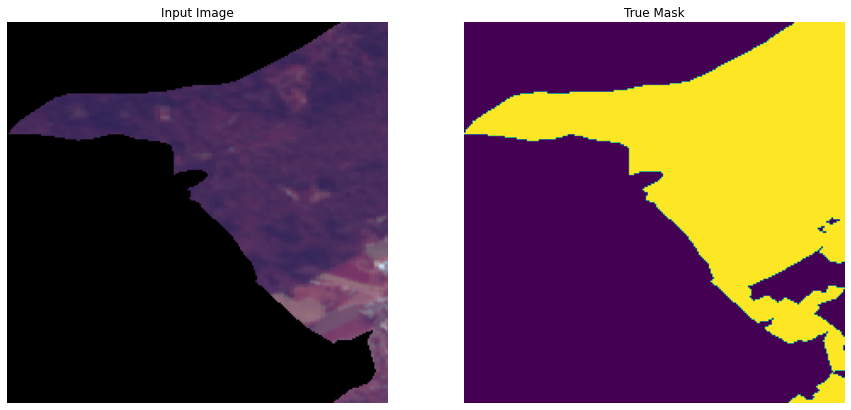

In [ ]:
# Now we will display some samples from the datasets

def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()
  
display_num = 1
r_choices = np.random.choice(num_foreground_examples, 1)
for i in range(0, display_num * 2, 2):
  img_num = r_choices[i // 2]

temp_ds = get_baseline_dataset(foreground_list_x[img_num:img_num+1], 
                               foreground_list_y[img_num:img_num+1],
                               preproc_fn=tr_preprocessing_fn,
                               batch_size=1,
                               shuffle=False)

# Let's examine some of these augmented images

iterator = iter(temp_ds)
next_element = iterator.get_next()

batch_of_imgs, label = next_element

# Running next element in our graph will produce a batch of images

sample_image, sample_mask = batch_of_imgs[0], label[0,:,:,:]

# display sample train image
display([sample_image, sample_mask])

...same check for the validation images:

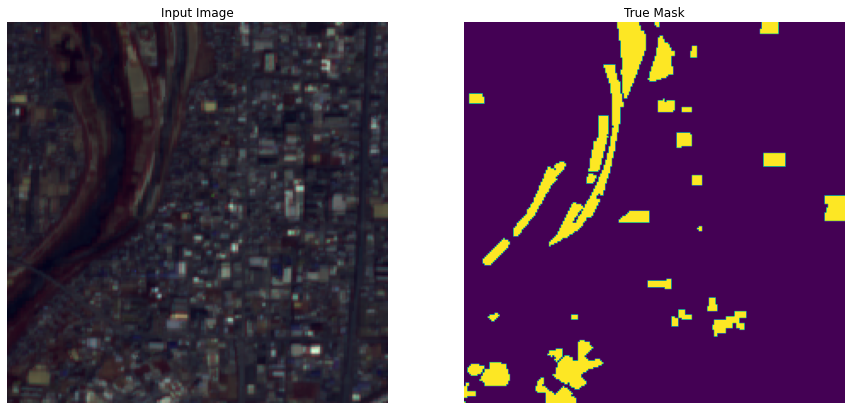

In [ ]:
# reset the forground list to capture the validation images
foreground_list_x = []
foreground_list_y = []
for x,y in zip(x_val_filenames, y_val_filenames): 
    img = np.array(Image.open(y)) 
    if img.max()>0:
        foreground_list_x.append(x)
        foreground_list_y.append(y)

num_foreground_examples = len(foreground_list_y)

display_num = 1
r_choices = np.random.choice(num_foreground_examples, 1)
for i in range(0, display_num * 2, 2):
  img_num = r_choices[i // 2]

temp_ds = get_baseline_dataset(foreground_list_x[img_num:img_num+1], 
                               foreground_list_y[img_num:img_num+1],
                               preproc_fn=val_preprocessing_fn,
                               batch_size=1,
                               shuffle=False)

# Let's examine some of these augmented images

iterator = iter(temp_ds)
next_element = iterator.get_next()

batch_of_imgs, label = next_element

# Running next element in our graph will produce a batch of images

sample_image, sample_mask = batch_of_imgs[0], label[0,:,:,:]

# display sample validation image
display([sample_image, sample_mask])

...same check for the test images:


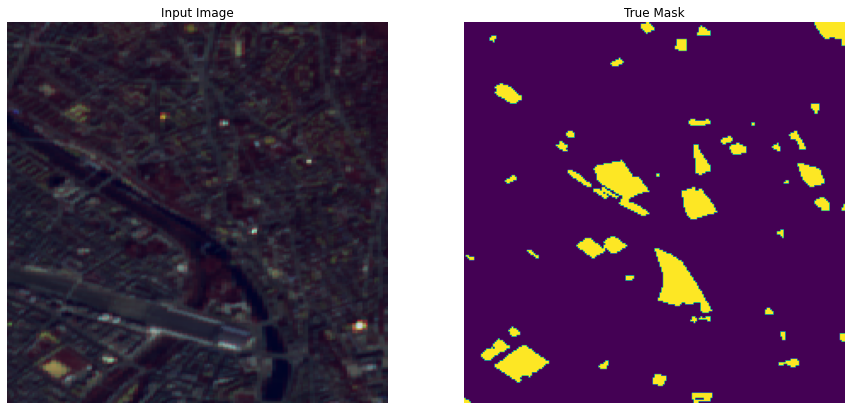

In [ ]:
# reset the forground list to capture the test images
foreground_list_x = []
foreground_list_y = []
for x,y in zip(x_test_filenames, y_test_filenames): 
    img = np.array(Image.open(y)) 
    if img.max()>0:
        foreground_list_x.append(x)
        foreground_list_y.append(y)

num_foreground_examples = len(foreground_list_y)

display_num = 4
r_choices = np.random.choice(num_foreground_examples, display_num)
for i in range(0, display_num * 2, 2):
  img_num = r_choices[i // 2]

temp_ds = get_baseline_dataset(foreground_list_x[img_num:img_num+1], 
                               foreground_list_y[img_num:img_num+1],
                               preproc_fn=test_preprocessing_fn,
                               batch_size=1,
                               shuffle=False)

# Let's examine some of these augmented images

iterator = iter(temp_ds)
next_element = iterator.get_next()

batch_of_imgs, label = next_element

# Running next element in our graph will produce a batch of images

sample_image, sample_mask = batch_of_imgs[0], label[0,:,:,:]

# display sample test image
display([sample_image, sample_mask])

### Define the model

The model being used here is a modified U-Net. A U-Net consists of an encoder (downsampler) and decoder (upsampler). In-order to learn robust features, and reduce the number of trainable parameters, a pretrained model can be used as the encoder. Thus, the encoder for this task will be a pretrained MobileNetV2 model, whose intermediate outputs will be used, and the decoder will be the upsample block already implemented in TensorFlow Examples in the Pix2pix tutorial.

The reason to output ten channels is because there are ten possible labels for each pixel. Think of this as multi-classification where each pixel is being classified into ten classes.

As mentioned, the encoder will be a pretrained MobileNetV2 model which is prepared and ready to use in tf.keras.applications. The encoder consists of specific outputs from intermediate layers in the model. Note that the encoder will not be trained during the training process.

In [ ]:
# set number of model output channels to the number of classes (including background)
OUTPUT_CHANNELS = 2
pre_trained = True
if pre_trained:
  weights = 'imagenet'
else:
  weights = None

base_model = tf.keras.applications.MobileNetV2(input_shape=[height, width, channels], weights=weights, include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = not pre_trained

The decoder/upsampler is simply a series of upsample blocks implemented in TensorFlow examples.

In [ ]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[height,width,channels])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 224x224

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

### Train the model

Now, all that is left to do is to compile and train the model. The loss being used here is losses.SparseCategoricalCrossentropy(from_logits=True). The reason to use this loss function is because the network is trying to assign each pixel a label, just like multi-class prediction. In the true segmentation mask, each pixel has a value between 0-9. The network here is outputting ten channels. Essentially, each channel is trying to learn to predict a class, and losses.SparseCategoricalCrossentropy(from_logits=True) is the recommended loss for such a scenario. Using the output of the network, the label assigned to the pixel is the channel with the highest value. This is what the create_mask function is doing.

Notice there is a class imbalance problem in the dataset. For that reason, we will use a loss function called focal loss. It uses a parameter to weigh the losses contributed by each class to prevent bias towards the over-represented.

In [ ]:
# Optional, you can load the model from the best version
load_from_checkpoint = False

save_model_path = os.path.join(root_dir,'model_out/best_model_unet.h5')

model = unet_model(OUTPUT_CHANNELS)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=SparseCategoricalFocalLoss(gamma=2, from_logits=True),
              metrics=['accuracy'])

if load_from_checkpoint == True:
  model.load_weights(save_model_path)

Let's try out the pre-trained model to see what it predicts before training.

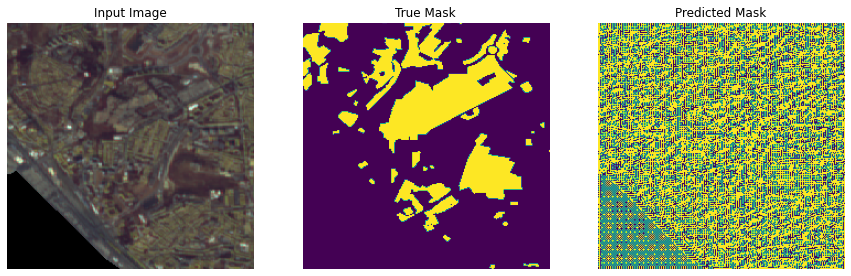

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image[0])
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    mp = create_mask(model.predict(sample_image[tf.newaxis, ...]))
    mpe = tf.keras.backend.eval(mp)
    display([sample_image, sample_mask, mpe])

show_predictions()

Let's observe how the model improves while it is training. To accomplish this task, a callback function is defined below to plot a validation image and it's predicted mask after each epoch.

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

callbacks= [
                      # to show samples after each epoch
                      DisplayCallback(),
                      # if no accuracy improvements we can stop the training directly
                      tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
                      # to save checkpoints
                      tf.keras.callbacks.ModelCheckpoint(save_model_path, verbose=1, save_best_only=True, save_weights_only=False)
                  ]

#### Fit and View
Now we will actually train the model for 100 epochs (full cycles through the training dataset), visualizing predictions on a validation image after each epoch.

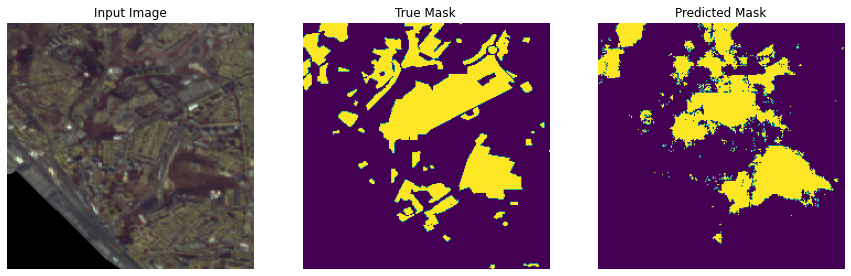


Sample Prediction after epoch 24


Epoch 00024: val_loss did not improve from 0.05991
Epoch 00024: early stopping


In [ ]:
EPOCHS = 100

model_history = model.fit(train_ds, 
                   steps_per_epoch=int(np.ceil(num_train_examples / float(batch_size))),
                   epochs=EPOCHS,
                   validation_data=val_ds,
                   validation_steps=int(np.ceil(num_val_examples / float(batch_size))),
                   callbacks = callbacks)


Plot the model's learning curve over time.

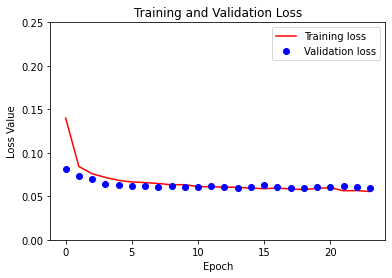

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(len(model_history.history['loss']))

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 0.25])
plt.legend()
plt.show()

---------------------------------

### Make predictions

Let's make some predictions. In the interest of saving time, the number of epochs was kept small, but you may set this higher to achieve more accurate results.

In [ ]:
# Optional, you can load the model from the best version saved or memmory
load_from_checkpoint = True
if load_from_checkpoint == True:
  model.load_weights(save_model_path)
else:
  print("inferencing from in memory model")

In [ ]:
def get_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      return pred_mask
  else:
    pred_mask = create_mask(model.predict(sample_image[tf.newaxis, ...]))
    pred_mask = tf.keras.backend.eval(pred_mask)
    return pred_mask

#### Multi image example

['/content/gdrive/MyDrive/how-green-is/sentinel2_images/places/sentinel2_Lisbon_Grande_Lisboa_Area_Metropolitana_de_Lisboa_Portugal/tiles/imgs_2020/tile_448_224_.png', '/content/gdrive/MyDrive/how-green-is/sentinel2_images/places/sentinel2_Lisbon_Grande_Lisboa_Area_Metropolitana_de_Lisboa_Portugal/tiles/imgs_2020/tile_448_448_.png', '/content/gdrive/MyDrive/how-green-is/sentinel2_images/places/sentinel2_Lisbon_Grande_Lisboa_Area_Metropolitana_de_Lisboa_Portugal/tiles/imgs_2020/tile_224_896_.png', '/content/gdrive/MyDrive/how-green-is/sentinel2_images/places/sentinel2_Lisbon_Grande_Lisboa_Area_Metropolitana_de_Lisboa_Portugal/tiles/imgs_2020/tile_224_1120_.png', '/content/gdrive/MyDrive/how-green-is/sentinel2_images/places/sentinel2_Lisbon_Grande_Lisboa_Area_Metropolitana_de_Lisboa_Portugal/tiles/imgs_2020/tile_224_672_.png', '/content/gdrive/MyDrive/how-green-is/sentinel2_images/places/sentinel2_Lisbon_Grande_Lisboa_Area_Metropolitana_de_Lisboa_Portugal/tiles/imgs_2020/tile_448_0_.png'

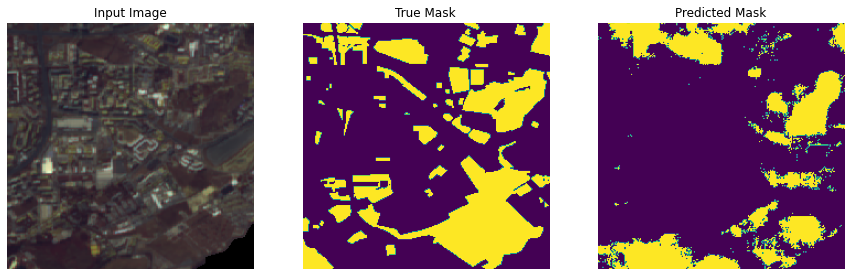

<BatchDataset shapes: ((None, 224, 224, 3), (None, 224, 224, 1)), types: (tf.float32, tf.uint8)>
(224, 224, 3)
12.215041
['/content/gdrive/MyDrive/how-green-is/sentinel2_images/places/sentinel2_Lisbon_Grande_Lisboa_Area_Metropolitana_de_Lisboa_Portugal/tiles/labels/tile_448_448_.png']
[0 1]


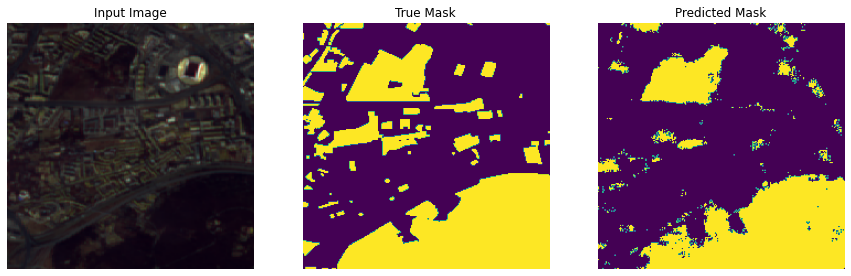

<BatchDataset shapes: ((None, 224, 224, 3), (None, 224, 224, 1)), types: (tf.float32, tf.uint8)>
(224, 224, 3)
8.014229
['/content/gdrive/MyDrive/how-green-is/sentinel2_images/places/sentinel2_Lisbon_Grande_Lisboa_Area_Metropolitana_de_Lisboa_Portugal/tiles/labels/tile_224_896_.png']
[0 1]


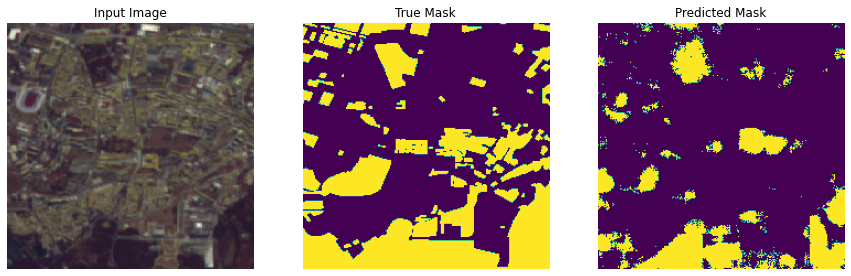

<BatchDataset shapes: ((None, 224, 224, 3), (None, 224, 224, 1)), types: (tf.float32, tf.uint8)>
(224, 224, 3)
9.424385
['/content/gdrive/MyDrive/how-green-is/sentinel2_images/places/sentinel2_Lisbon_Grande_Lisboa_Area_Metropolitana_de_Lisboa_Portugal/tiles/labels/tile_224_1120_.png']
[0 1]


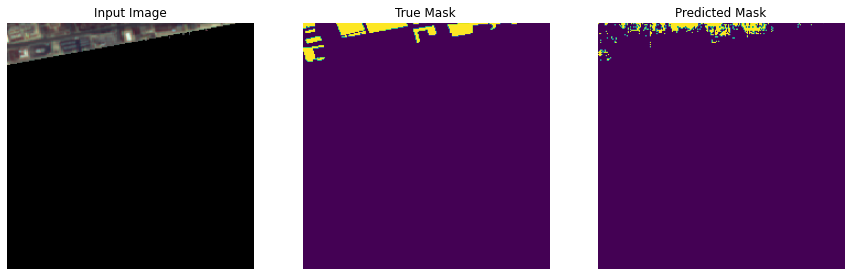

<BatchDataset shapes: ((None, 224, 224, 3), (None, 224, 224, 1)), types: (tf.float32, tf.uint8)>
(224, 224, 3)
10.850918
['/content/gdrive/MyDrive/how-green-is/sentinel2_images/places/sentinel2_Lisbon_Grande_Lisboa_Area_Metropolitana_de_Lisboa_Portugal/tiles/labels/tile_224_672_.png']
[0 1]


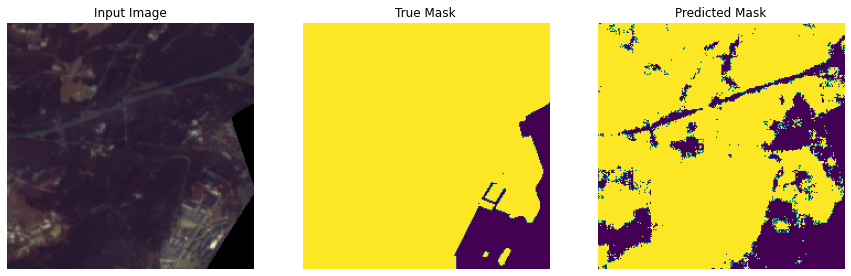

<BatchDataset shapes: ((None, 224, 224, 3), (None, 224, 224, 1)), types: (tf.float32, tf.uint8)>
(224, 224, 3)
8.375012
['/content/gdrive/MyDrive/how-green-is/sentinel2_images/places/sentinel2_Lisbon_Grande_Lisboa_Area_Metropolitana_de_Lisboa_Portugal/tiles/labels/tile_448_0_.png']
[0 1]


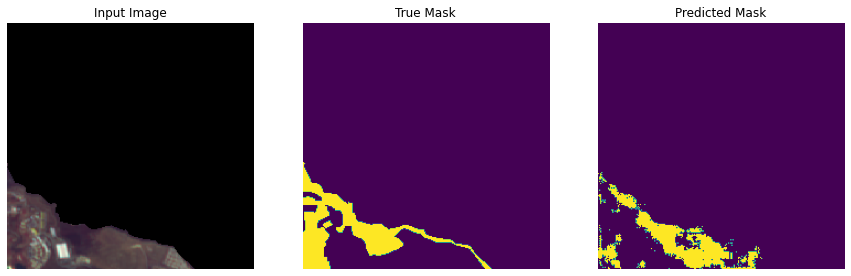

<BatchDataset shapes: ((None, 224, 224, 3), (None, 224, 224, 1)), types: (tf.float32, tf.uint8)>
(224, 224, 3)
9.396057
['/content/gdrive/MyDrive/how-green-is/sentinel2_images/places/sentinel2_Lisbon_Grande_Lisboa_Area_Metropolitana_de_Lisboa_Portugal/tiles/labels/tile_224_448_.png']
[0 1]


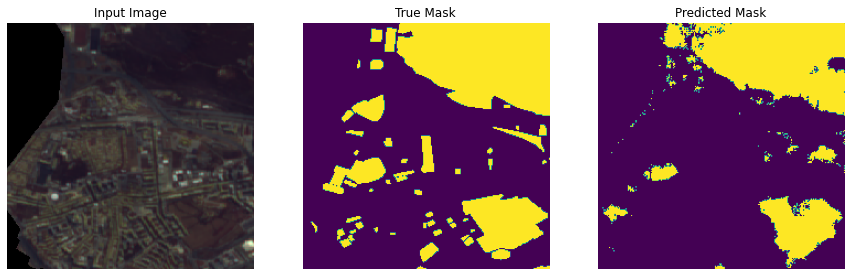

<BatchDataset shapes: ((None, 224, 224, 3), (None, 224, 224, 1)), types: (tf.float32, tf.uint8)>
(224, 224, 3)
11.452537
['/content/gdrive/MyDrive/how-green-is/sentinel2_images/places/sentinel2_Lisbon_Grande_Lisboa_Area_Metropolitana_de_Lisboa_Portugal/tiles/labels/tile_1120_448_.png']
[0 1]


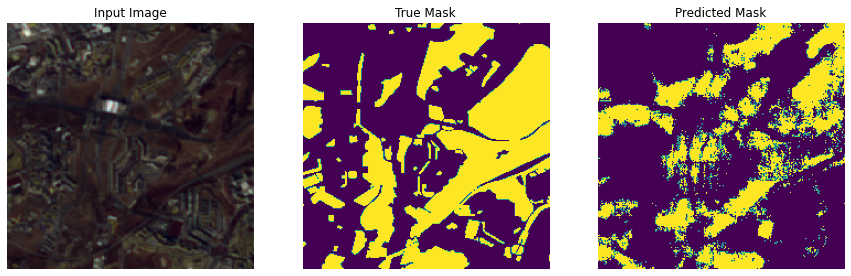

<BatchDataset shapes: ((None, 224, 224, 3), (None, 224, 224, 1)), types: (tf.float32, tf.uint8)>
(224, 224, 3)
6.6424417
['/content/gdrive/MyDrive/how-green-is/sentinel2_images/places/sentinel2_Lisbon_Grande_Lisboa_Area_Metropolitana_de_Lisboa_Portugal/tiles/labels/tile_1120_672_.png']
[0 1]


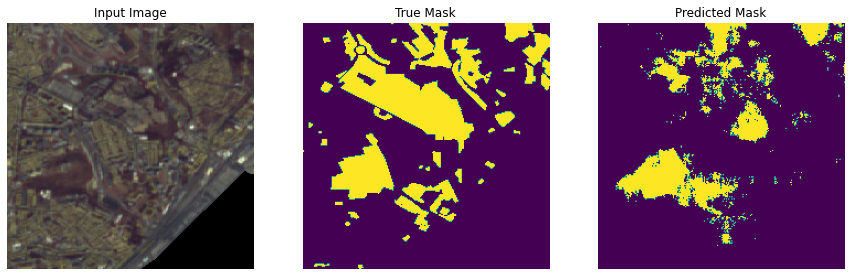

In [ ]:
tiled_prediction_dir = os.path.join(personal_dir,'predictions_test/')
if not os.path.exists(tiled_prediction_dir):
    os.makedirs(tiled_prediction_dir)
    
pred_masks = []
true_masks = []

print(foreground_list_x)

for i in range(0, 9):
    img_num = i

    temp_ds = get_baseline_dataset(foreground_list_x[img_num:img_num+1], 
                                   foreground_list_y[img_num:img_num+1],
                                   preproc_fn=tr_preprocessing_fn,
                                   batch_size=1,
                                   shuffle=False)
    print(temp_ds)

    # Let's examine some of these augmented images

    iterator = iter(temp_ds)
    next_element = iterator.get_next()

    batch_of_imgs, label = next_element

    # Running next element in our graph will produce a batch of images

    sample_image, sample_mask = batch_of_imgs[0], label[0,:,:,:]
    sample_mask_int = tf.dtypes.cast(sample_mask, tf.int32)
    print(sample_image.shape)
    print(np.max(sample_image))
    true_masks.append(sample_mask_int)
    print(foreground_list_y[img_num:img_num+1])
    print(np.unique(sample_mask_int))

    # run and plot predicitions

    show_predictions()
    pred_mask = get_predictions()
    pred_masks.append(pred_mask)
    
    # save prediction images to file

    filename_split = os.path.splitext(foreground_list_x[img_num]) 
    filename_zero, fileext = filename_split 
    basename = os.path.basename(filename_zero) 
    tf.keras.preprocessing.image.save_img(tiled_prediction_dir+'/'+basename+".png",pred_mask)    

### Evaluate Model

Compute confusion matrix from all predicted images and their ground truth label masks. 

In [ ]:
# flatten our tensors and use scikit-learn to create a confusion matrix
flat_preds = tf.reshape(pred_masks, [-1]) 
flat_truth = tf.reshape(true_masks, [-1]) 
cm = confusion_matrix(flat_truth, flat_preds, labels=list(range(OUTPUT_CHANNELS)))

In [ ]:
# check values in predicted masks vs truth masks
check_preds = tf.keras.backend.eval(flat_preds)
check_truths = tf.keras.backend.eval(flat_truth)
print(np.unique(check_preds), np.unique(check_truths))

[0 1] [0 1]


(1.5, -0.5)

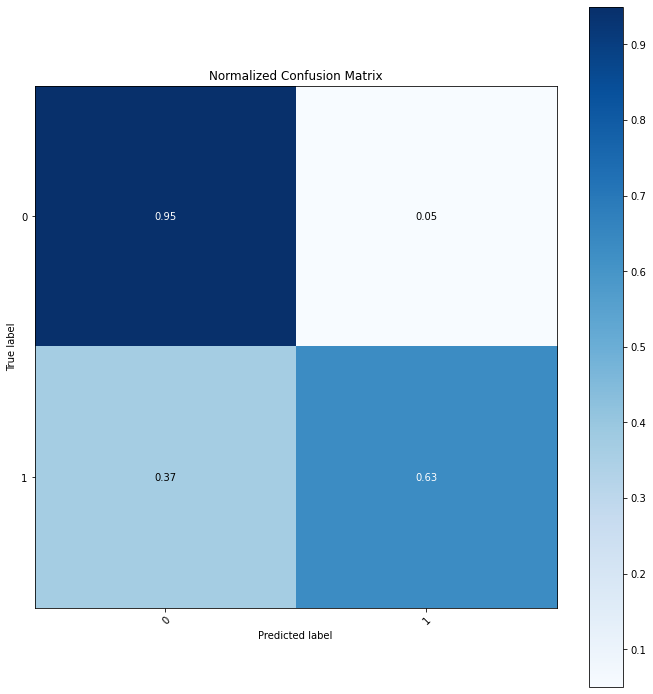

In [ ]:
classes = [0,1]

%matplotlib inline
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=list(range(OUTPUT_CHANNELS)), yticklabels=list(range(OUTPUT_CHANNELS)),
       title='Normalized Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = '.2f' #'d' # if normalize else 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout(pad=2.0, h_pad=2.0, w_pad=2.0)
ax.set_ylim(len(classes)-0.5, -0.5)

Now let's compute the f1 score

F1 = 2 * (precision * recall) / (precision + recall)


In [ ]:
# compute f1 score
f1_score(flat_truth, flat_preds, average='macro')

0.8104398722725468


(1275, 1976)
224 224
(1344, 2016, 1)
/content/gdrive/MyDrive/how-green-is/sentinel2_images/places/sentinel2_Zurich_District_Zurich_Zurich_Switzerland/tiles/imgs_2020/tile_1792_1120_.png


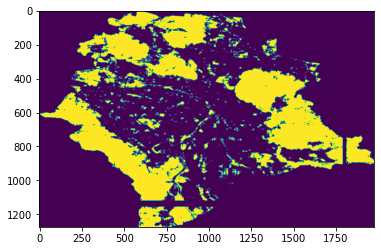

In [ ]:
output_file = personal_dir + 'final.tif'
    
# sat_folders_test = ['sentinel2_Berlin_Germany13.156128_52.392363_13.623047_52.629729']
save_model_path = os.path.join(root_dir,'model_out/best_model_unet.h5')
model = tf.keras.models.load_model(save_model_path)

def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def process_img_path(fname):
  img_str = tf.io.read_file(fname)
  img = tf.image.decode_png(img_str, dtype= tf.uint16)
  img = tf.image.resize_with_pad(img, height, width)
  img = tf.image.per_image_standardization(img)
  return img, fname

def get_dataset(filenames, threads=5):           
  # Create a dataset from the filenames 
  dataset = tf.data.Dataset.from_tensor_slices(filenames)
  # Map our preprocessing function to every element in our dataset, taking
  # advantage of multithreading
  dataset = dataset.map(process_img_path, num_parallel_calls=threads)  
  return dataset

folder = sat_folders_test[1]

# direct prediction
x_filenames = glob.glob(sat_data_dir + folder + '/tiles/imgs_'+year+'/*.png')
print()
temp_ds = get_dataset(x_filenames)


true_mask = rasterio.open(sat_data_dir + folder + '/labels.tif')
src_meta = true_mask.meta
print(true_mask.read(1).shape)
print(height,width)
full_height = (int(src_meta['height']/height) +1)*height
full_width = (int(src_meta['width']/width)+1)*width
full_pred = np.zeros((full_height, full_width,  1))
print(full_pred.shape)
for img, file in iter(temp_ds):
    fname = file.numpy().decode('UTF-8')
    loc = [int(i) for i in os.path.basename(fname).split('_')[1:3]]
    nrow_s, nrow_e = loc[1], min(loc[1]+height, full_height)
    ncol_s, ncol_e = loc[0], min(loc[0]+width, full_width)
    img=img[:,:,:channels]                                                                             
    pred_mask = create_mask(model.predict(img[tf.newaxis, ...]))
    pred_mask = tf.keras.backend.eval(pred_mask)
    full_pred[nrow_s:nrow_e,ncol_s:ncol_e] = pred_mask

full_pred = full_pred[:src_meta['height'],:src_meta['width'],:]
print(fname)
show(full_pred) # Check to make sure the merge looks good.

pred_file = rasterio.open(output_file, 'w', driver='Gtiff',
                                width=src_meta['width'], height=src_meta['height'],
                                count=1,
                                crs=src_meta['crs'],
                                transform=src_meta['transform'],
                                dtype='uint8')
pred_file.write(full_pred.transpose((2,0,1)))
pred_file.close()

(1275, 1976, 3)
(1275, 1976, 1)
(1275, 1976, 1)


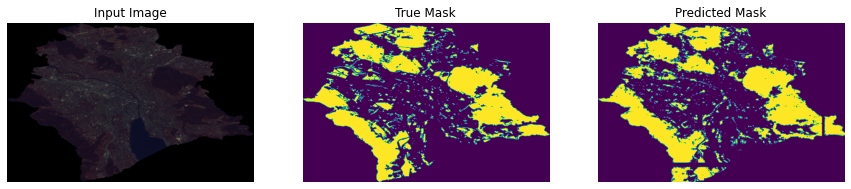

predicted % of green: 23.96%
true % of green (OSM) 23.03%


In [ ]:
predict = np.transpose(rasterio.open(output_file).read(),(1,2,0))
true =  np.transpose(rasterio.open(sat_data_dir + folder + '/labels.tif').read(),(1,2,0))
origin =  np.transpose(rasterio.open(sat_data_dir + folder + '/'+year+'_stack.tif').read(),(1,2,0))
print(origin.shape)
print(true.shape)
print(predict.shape)

def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

display([origin, true, predict])

pred_green = np.sum(predict)/np.size(predict)
print('predicted % of green: {:.2%}'.format(pred_green))
true_green = np.sum(true)/np.size(true)
print('true % of green (OSM) {:.2%}'.format(true_green))

In [ ]:
import folium

stack = rasterio.open(output_file)
meta = stack.meta
bounds = rasterio.transform.array_bounds(meta['height'], meta['width'], meta['transform'])
#returns [west, south, east, north bounds], convert to folium format: [[N_lat, W_long], [S_lat, E_long]]
bounds = [[bounds[3], bounds[0]], [bounds[1], bounds[2]]]

# Final review of the labels over detailed sat images
# Center the map at the center of the area of interest, thanks to latitude and longitude coordinates:
m = folium.Map(height=500)

tile = folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True,
        opacity= 0.8
       ).add_to(m)

# Without Mercator projection 
folium.raster_layers.ImageOverlay(
    name='Green labels (True)',
    image=true,
    bounds=bounds,
    opacity=0.2,
    interactive=True,
    cross_origin=False,
    colormap=lambda x: (0, 1, 0, x),
).add_to(m)

# Without Mercator projection 
folium.raster_layers.ImageOverlay(
    name='Green labels (Predicted)',
    image=predict,
    bounds=bounds,
    opacity=0.2,
    interactive=True,
    cross_origin=False,
    colormap=lambda x: (1, 0, 0, x),
).add_to(m)

# Without Mercator projection 
folium.raster_layers.ImageOverlay(
    name='Satellite image',
    image=origin,
    bounds=bounds,
    interactive=True,
    show=False
#    cross_origin=False,
).add_to(m)


if 'place_area' in globals(): 
  folium.GeoJson(place_area, style_function=lambda x: {'fillColor': '#00000000'}, name='Area contour').add_to(m)

m.add_child(folium.LayerControl())
m.fit_bounds(bounds)
m